# Train A Shape Classifier Model



In [6]:
import json
import os

train_data_root = "../datasets/train"
test_data_root = "../datasets/test"

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations (including resizing and normalization)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (black and white images)
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images (mean=0.5, std=0.5 for grayscale)
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=train_data_root, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class names (optional)
print(f'Classes: {train_dataset.classes}')

# 2. Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # change in coming channel to 16
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes: circle, triangle, rectangle
        
    def forward(self, x):
        x = F.relu(self.conv1(x))   # First Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = F.relu(self.conv2(x))   # Second Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = x.view(x.size(0), -1)   # Flatten
        x = F.relu(self.fc1(x))     # Fully Connected Layer 1
        x = self.fc2(x)             # Fully Connected Layer 2 (output)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total # change the accuracy calculation
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

    return total, predicted


Classes: ['circle', 'diamond', 'triangle']


# Train

In [9]:
all_label, predicted_label = train_model(model, train_loader, criterion, optimizer, epochs=15)

Epoch [1/15], Loss: 1.0989, Accuracy: 38.00%
Epoch [2/15], Loss: 1.0185, Accuracy: 47.86%
Epoch [3/15], Loss: 0.8985, Accuracy: 57.29%
Epoch [4/15], Loss: 0.7515, Accuracy: 69.00%
Epoch [5/15], Loss: 0.5426, Accuracy: 80.86%
Epoch [6/15], Loss: 0.3537, Accuracy: 88.86%
Epoch [7/15], Loss: 0.1992, Accuracy: 95.71%
Epoch [8/15], Loss: 0.1195, Accuracy: 97.57%
Epoch [9/15], Loss: 0.0635, Accuracy: 99.43%
Epoch [10/15], Loss: 0.0398, Accuracy: 99.57%
Epoch [11/15], Loss: 0.0284, Accuracy: 99.71%
Epoch [12/15], Loss: 0.0136, Accuracy: 100.00%
Epoch [13/15], Loss: 0.0084, Accuracy: 100.00%
Epoch [14/15], Loss: 0.0055, Accuracy: 100.00%
Epoch [15/15], Loss: 0.0042, Accuracy: 100.00%


# Test 

In [11]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

def test(model, test_loader):
    """Print the Precision, Recall and F1-score for the trained model
    """

    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Print results
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'Confusion Matrix:\n{conf_matrix}')

    return accuracy, precision, recall, f1, conf_matrix

In [ ]:
test(model, test_loader)

# Show Predictions


In [12]:
import matplotlib.pyplot as plt

def show_prediction(model, image):
    """Pass the image to the model and overlay the predicted shape and confidence on the input
    image and display it
    """
    model.eval()

    # Define transformations (including resizing and normalization)
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (black and white images)
        transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize the images (mean=0.5, std=0.5 for grayscale)
    ])

    # Apply transformation
    image_tensor = transform(image).unsqueeze(0).to(device)  

    with torch.no_grad(): 
        output = model(image_tensor)  
        probabilities = torch.softmax(output, dim=1) 
        confidence, predicted_class = torch.max(probabilities, 1)  

    predicted_label = test_dataset.classes[predicted_class.item()]
    confidence = confidence.item()

    # Convert back to displayable format 
    image_to_display = image_tensor.squeeze(0).cpu().numpy()  # Remove batch dim, convert to NumPy
    image_to_display = (image_to_display * 0.5) + 0.5  # Denormalize

    # Display image with prediction
    plt.imshow(image_to_display.squeeze(), cmap='gray')
    plt.title(f'Predicted: {predicted_label} ({confidence * 100:.2f}%)')
    plt.axis('off')
    plt.show()

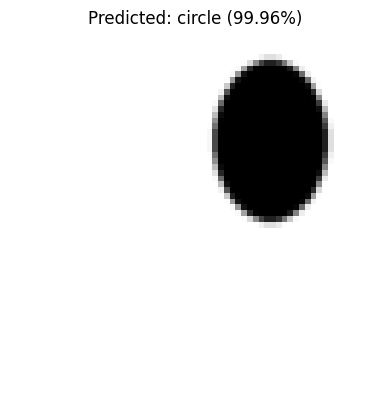

In [14]:
from PIL import Image
image = Image.open("../datasets/test/circle/circle_103.png")

show_prediction(model, image)